### Comparative Analysis of NLP Architectures for Cyberbullying Detection and Classification Across Social Media and Online Gaming Platforms

In [1]:
! pip install moviepy keras speechrecognition gTTS pydub



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 29.4 MB/s eta 0:00:00


### This code imports necessary libraries and modules for text and video processing

In [2]:
import pandas as pd
import numpy as np
import re
import json

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer

# TensorFlow and Keras for building and training neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization,
                                     Activation, Flatten, LSTM, Bidirectional, GRU)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric, Precision, Recall

# Sklearn for preprocessing and model evaluation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Moviepy for video processing
from moviepy.editor import VideoFileClip

# Speech Recognition for converting speech to text
import speech_recognition as sr


This code snippet loads a dataset from a specified CSV file path containing cyberbullying-related tweets into a Pandas DataFrame and then prints the first few rows of the DataFrame to provide a preview of the data structure and contents.

In [3]:

# Load the dataset
dataset_path = '/content/cyberbullying_tweets.csv'
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataframe
print(df.head())


                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


###Text Preprocessing for Cyberbullying Detection
This script initializes necessary tools and functions for preprocessing text data, specifically targeting the enhancement of a dataset comprising cyberbullying-related tweets. The preprocessing steps include downloading essential NLTK data packages for tokenization and stopword removal, initializing a stemmer for word normalization, and defining a function to clean the text.

In [4]:
# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the stemmer
stemmer = PorterStemmer()

def clean_and_preprocess_text(text):
    # Normalization: Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Removing user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercasing
    text = text.lower()
    # Sentence Segmentation
    sentences = sent_tokenize(text)
    processed_text = []
    for sentence in sentences:
        # Tokenization
        tokens = word_tokenize(sentence)
        # Stop Word Removal
        tokens = [token for token in tokens if token not in stopwords.words('english')]
        tokens = [stemmer.stem(token) for token in tokens]
        processed_text.extend(tokens)
    return " ".join(processed_text)

df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_and_preprocess_text)

# Display the cleaned and preprocessed text
print(df[['tweet_text', 'cleaned_tweet_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                          tweet_text  \
0  In other words #katandandre, your food was cra...   
1  Why is #aussietv so white? #MKR #theblock #ImA...   
2  @XochitlSuckkks a classy whore? Or more red ve...   
3  @Jason_Gio meh. :P  thanks for the heads up, b...   
4  @RudhoeEnglish This is an ISIS account pretend...   

                                  cleaned_tweet_text  
0                 word katandandr food crapilici mkr  
1  aussietv white mkr theblock imacelebrityau tod...  
2                     classi whore red velvet cupcak  
3  meh p thank head concern anoth angri dude twitter  
4  isi account pretend kurdish account like islam...  


This code loads a dataset from a CSV file containing information about cyberbullying, extracts unique categories of cyberbullying from the 'cyberbullying_type' column, and prints these categories to identify the different types of cyberbullying present in the data.

In [43]:
# Load the new dataset
dataset_path = '/content/cyberbullying_tweets.csv'
dataset = pd.read_csv(dataset_path)

# Extract unique labels from the 'cyberbullying_type' column
unique_labels = df['cyberbullying_type'].unique()
print("Unique labels:", unique_labels)


Unique labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


In [44]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = '/content/cyberbullying_tweets.csv'
df = pd.read_csv(dataset_path)

df['cyberbullying_type'] = df['cyberbullying_type'].replace(['gender', 'religion', 'age', 'ethnicity'], 'cyberbullying')

unique_labels = df['cyberbullying_type'].unique()

# Save the unique labels to a .npy file
labels_save_path = '/content/unique_labels.npy'
np.save(labels_save_path, unique_labels)

print("Unique labels:", unique_labels)
print(f"Unique labels saved to {labels_save_path}")


Unique labels: ['not_cyberbullying' 'cyberbullying' 'other_cyberbullying']
Unique labels saved to /content/unique_labels.npy


In [45]:

y = dataset['cyberbullying_type']

encoder = LabelBinarizer()
y = encoder.fit_transform(y)
print(y[61])


[0 0 0 1 0 0]


This code tokenizes and pads text data from a DataFrame for neural network input, encodes categorical labels, ensures feature-label alignment, splits the data into training and test sets, and displays the shapes of the processed feature and label arrays to confirm their readiness for model training.

In [46]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweet_text'])
X_sequences = tokenizer.texts_to_sequences(df['tweet_text'])
X_padded = pad_sequences(X_sequences, maxlen=200)

# Encoding for labels (y)
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(df['cyberbullying_type'])

# Verify alignment
assert X_padded.shape[0] == y_encoded.shape[0], "Features and labels are misaligned."

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.20, random_state=42)

# Display shapes of features and labels
print(f"Shape of X_padded: {X_padded.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")


Shape of X_padded: (47692, 200)
Shape of y_encoded: (47692, 3)


This code configures a tokenizer on tweet texts to build a vocabulary, transforms texts into sequences and pads them to uniform length, encodes categorical labels, and splits the dataset into training and test sets for subsequent machine learning model training.

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweet_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['tweet_text'])
# Pad the sequences
maxlen = 200
X_padded = pad_sequences(X, maxlen=maxlen)

# Encode the labels
lb = LabelBinarizer()
y = lb.fit_transform(df['cyberbullying_type'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.20, random_state=42)




In [48]:
num_classes = df['cyberbullying_type'].nunique()
print(f"Number of unique classes: {num_classes}")


Number of unique classes: 3


### Integration of GloVe Embeddings for Text Analysis
This code snippet initializes a dictionary to store pre-trained GloVe word embeddings from a file, mapping each word to its corresponding 200-dimensional vector. It then creates an embedding matrix tailored for the vocabulary of the dataset, ensuring that each word found in the dataset's text has its corresponding vector from GloVe, thereby enhancing the feature set for more effective machine learning models, particularly in deep learning architectures that benefit from such rich, pre-trained embeddings.

In [11]:
embeddings_dictionary = dict()
with open('/content/glove.6B.200d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        if vector_dimensions.shape[0] == 200:
            embeddings_dictionary[word] = vector_dimensions

embedding_matrix = np.zeros((vocab_size, 200))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if index < vocab_size:
            embedding_matrix[index] = embedding_vector


### Custom F1 Score Metric Class for TensorFlow
This class defines a custom F1Score metric, inheriting from TensorFlow's Metric class, to evaluate model performance by harmonizing precision and recall into a single metric. It constructs precision and recall metrics within its context, updates their states with true and predicted labels during model training or evaluation, and computes the F1 Score as the harmonic mean of precision and recall.

In [12]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision(name='precision')
        self.recall = Recall(name='recall')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


### Neural Network Architecture for Text Classification
This code snippet sets up a sequential neural network model specifically tailored for text classification tasks. The model starts with an Embedding layer pre-loaded with a GloVe embeddings matrix, making the layer non-trainable to preserve the pre-trained word vectors. It then uses a GRU layer, a type of recurrent neural network suitable for sequence data, with dropout to prevent overfitting.

In [13]:
model = Sequential([
    Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



### Training the Cyberbullying Detection Model
This section outlines the process for compiling and training a neural network model designed to detect types of cyberbullying. The model is compiled with the Adam optimizer, using a low learning rate to fine-tune pre-trained embeddings carefully. The loss function specified is 'categorical_crossentropy', suitable for multi-class classification, and it includes accuracy, precision, recall, and F1 Score as metrics to monitor during training.

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=+['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score()])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, callbacks=[early_stopping, reduce_lr], verbose=1)

# Save the model in the .h5 format
model_save_path_h5 = 'Cyber_Bullying_model_.h5'
model.save(model_save_path_h5)
print(f"Model saved to {model_save_path_h5}")




Epoch 1/30
239/239 [==============================] - ETA: 0s - loss: 0.9202 - accuracy: 0.6047 - precision: 0.7222 - recall: 0.3578 - f1_score: 0.4785

  m.reset_state()



239/239 [==============================] - 140s 563ms/step - loss: 0.9202 - accuracy: 0.6047 - precision: 0.7222 - recall: 0.3578 - f1_score: 0.4785 - val_loss: 0.7985 - val_accuracy: 0.6763 - val_precision: 0.7257 - val_recall: 0.6236 - val_f1_score: 0.6708 - lr: 1.0000e-04
Epoch 2/30
239/239 [==============================] - 138s 577ms/step - loss: 0.7927 - accuracy: 0.6894 - precision: 0.7515 - recall: 0.5748 - f1_score: 0.6514 - val_loss: 0.6709 - val_accuracy: 0.7002 - val_precision: 0.7712 - val_recall: 0.6497 - val_f1_score: 0.7053 - lr: 1.0000e-04
Epoch 3/30
239/239 [==============================] - 138s 578ms/step - loss: 0.5694 - accuracy: 0.7508 - precision: 0.8683 - recall: 0.6387 - f1_score: 0.7360 - val_loss: 0.4972 - val_accuracy: 0.7736 - val_precision: 0.8970 - val_recall: 0.6484 - val_f1_score: 0.7527 - lr: 1.0000e-04
Epoch 4/30
239/239 [==============================] - 134s 562ms/step - loss: 0.5068 - accuracy: 0.7741 - precision: 0.8867 - recall: 0.6606 - f1_scor

  saving_api.save_model(



Model saved to Cyber_Bullying_model_.h5


### visualization of the evaluation metrics

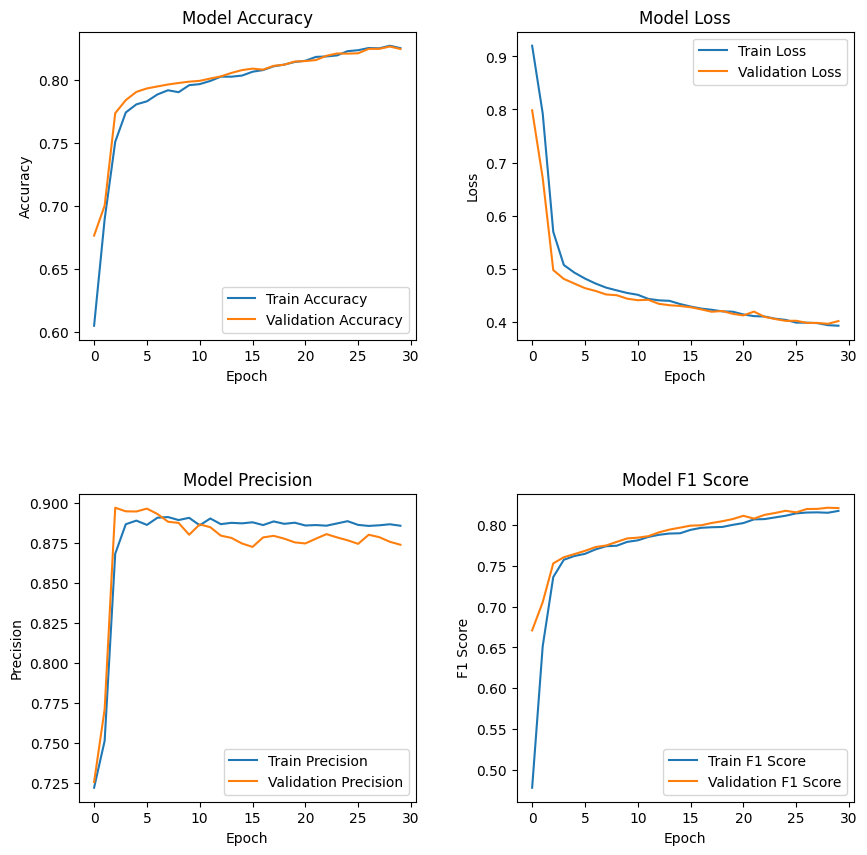

In [ ]:
import matplotlib.pyplot as plt

# Extract history from your GRU model training
history_dict = history.history

# Setup the figure and subplots
plt.figure(figsize=(10, 10))

# Plot for Accuracy
plt.subplot(221)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot for Loss
plt.subplot(222)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot for Precision
plt.subplot(223)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot for F1 Score
plt.subplot(224)
plt.plot(history_dict['f1_score'], label='Train F1 Score')
plt.plot(history_dict['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()


### Testing the Trained Model on New Data
This script demonstrates the application of a trained neural network model to new, unseen text data to evaluate its capability in detecting cyberbullying. The text is first preprocessed by tokenizing, removing stopwords, and stemming to format it similarly to the training data. It is then converted into a sequence and padded to match the input shape required by the model. Finally, the model, loaded from saved weights, predicts the category of cyberbullying, illustrating the model's practical use in identifying harmful content in real-world scenarios.








In [ ]:
import numpy as np
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
import pickle
import numpy as np
from keras.models import load_model

nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()

text = " This guy thinks I'm Randi Harper, have we met?"

def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return " ".join(stemmed_tokens)

preprocessed_text = preprocess_text(text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts([preprocessed_text])

# Convert the preprocessed text to sequences and pad them
sequences = tokenizer.texts_to_sequences([preprocessed_text])
X_test = pad_sequences(sequences, maxlen=200)

# Load the model and classes
model_path = '/content/Cyber_Bullying_model_.h5'
classes_path = '/content/unique_labels.npy'
model = load_model(model_path)
classes = np.load(classes_path, allow_pickle=True)

# Make predictions
pred = model.predict(X_test)
predicted_class = classes[np.argmax(pred, axis=1)]

print("Preprocessed text:", preprocessed_text)
print("Predicted class:", predicted_class)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 1s 724ms/step
Preprocessed text: guy think 'm randi harper , met ?
Predicted class: ['other_cyberbullying']


### Analyzing Audio for Cyberbullying Detection
This script extends the use of a trained cyberbullying detection model to the audio content by processing spoken words from an MP3 file. It first converts the audio into a WAV format suitable for analysis, then uses speech recognition to convert the audio to text, which is subsequently analyzed using the pretrained model. The process involves transforming the recognized speech into a sequence format compatible with the model, predicting the potential presence of cyberbullying, and providing a confidence score for the prediction, effectively applying the text-based model to multimedia content.

In [ ]:
from pydub import AudioSegment
import speech_recognition as sr
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_path, wav_path):
    sound = AudioSegment.from_mp3(mp3_path)
    sound.export(wav_path, format="wav")

# Load the trained model
model_path = '/content/Cyber_Bullying_model_.h5'
model = load_model(model_path)

# Load tokenizer
tokenizer_path = '/content/tokenizer.pickle'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load class labels
labels_path = '/content/unique_labels.npy'
labels = np.load(labels_path, allow_pickle=True)

def speech_to_text(audio_path='/content/welcome.wav'):
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data, language='en-US')
            return text
    except (sr.UnknownValueError, sr.RequestError) as e:
        return f"Speech Recognition Error: {e}"

def analyze_audio(audio_path):
    wav_path = '/content/welcome_converted.wav'
    convert_mp3_to_wav(audio_path, wav_path)

    # Perform speech recognition
    transcribed_text = speech_to_text(wav_path)
    if not transcribed_text:
        return "Error: No speech recognized", 0

    # Analyze the text
    sequence = tokenizer.texts_to_sequences([transcribed_text])
    padded_sequence = pad_sequences(sequence, maxlen=200)
    prediction = model.predict(padded_sequence)
    predicted_index = np.argmax(prediction, axis=1)[0]
    predicted_label = labels[predicted_index]
    confidence = prediction[0][predicted_index]

    return predicted_label, confidence

audio_path = '/content/welcome.mp3'
predicted_label, confidence = analyze_audio(audio_path)
print("Predicted Label:", predicted_label, "with confidence", confidence)


1/1 [==============================] - 0s 465ms/step
Predicted Label: other_cyberbullying with confidence 0.4406661


### CNN:
Using a CNN model tailored for text classification, this script defines a robust neural network architecture designed to effectively process embedded textual data. The model employs an Embedding layer initialized with pre-trained GloVe vectors, ensuring rich semantic representation while keeping the embeddings non-trainable to preserve their pre-learned associations. It features convolutional layers (Conv1D) with ReLU activation to capture spatial hierarchies in data, interspersed with BatchNormalization to stabilize learning and SpatialDropout1D to mitigate overfitting by dropping entire 1D feature maps. The architecture also includes MaxPooling1D for down-sampling and GlobalMaxPooling1D for capturing the most significant features before passing through fully connected layers.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Model Definition with Spatial Dropout and Batch Normalization
model_cnn = Sequential([
    Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    Conv1D(128, 5, activation='relu', padding='same'),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


### Training and Saving the Enhanced CNN Model
This segment details the compilation and training of an advanced convolutional neural network (CNN) model for text classification, configured with optimized learning parameters and specialized callbacks to adjust the learning rate dynamically. The model, leveraging layers like BatchNormalization and SpatialDropout1D for effective regularization, is trained on pre-defined training and validation sets, achieving refined generalization before being saved for future use.

In [ ]:
# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model_cnn.fit(X_train, y_train, epochs=15, batch_size=64,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr],
                        verbose=1)

# Save the model
model_save_path = 'modified_CNN_model.h5'
model_cnn.save(model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/15
597/597 [==============================] - 9s 10ms/step - loss: 0.6004 - accuracy: 0.7309 - val_loss: 0.4541 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 2/15
597/597 [==============================] - 5s 8ms/step - loss: 0.4726 - accuracy: 0.7805 - val_loss: 0.4231 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 3/15
597/597 [==============================] - 7s 11ms/step - loss: 0.4427 - accuracy: 0.7932 - val_loss: 0.4195 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 4/15
597/597 [==============================] - 5s 9ms/step - loss: 0.4162 - accuracy: 0.8068 - val_loss: 0.4111 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 5/15
597/597 [==============================] - 5s 8ms/step - loss: 0.3973 - accuracy: 0.8184 - val_loss: 0.4056 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 6/15
597/597 [==============================] - 7s 12ms/step - loss: 0.3791 - accuracy: 0.8261 - val_loss: 0.4031 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 7/15
597/597 [==============================] - 5s 9ms/step -

  saving_api.save_model(



Model saved to modified_CNN_model.h5


### visualization of the evaluation metrics for cnn model

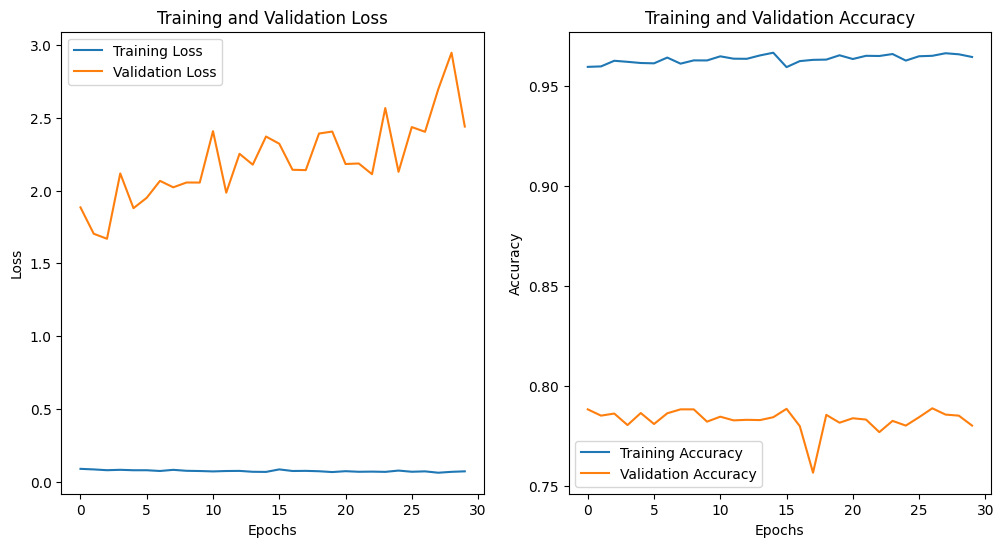

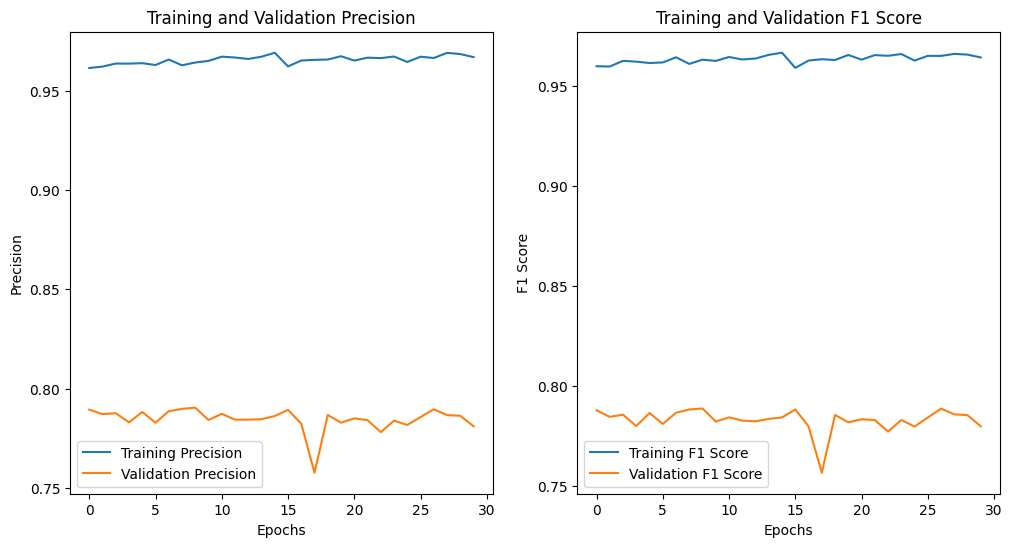

In [ ]:
import matplotlib.pyplot as plt

# Extract history from the training history object
history_dict = history_cnn.history

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plotting Precision and F1 Score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['f1_score'], label='Training F1 Score')
plt.plot(history_dict['val_f1_score'], label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()


### Testing the Trained CNN Model on New Data
This script demonstrates the application of a trained neural network model to new, unseen text data to evaluate its capability in detecting cyberbullying. The text is first preprocessed by tokenizing, removing stopwords, and stemming to format it similarly to the training data. It is then converted into a sequence and padded to match the input shape required by the model. Finally, the model, loaded from saved weights, predicts the category of cyberbullying, illustrating the model's practical use in identifying harmful content in real-world scenarios.

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Given text
text = " This guy thinks I am Randi Harper have we met"


tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# Convert the text to sequences and pad them
sequences = tokenizer.texts_to_sequences([text])
X_test = pad_sequences(sequences, maxlen=200)

# Load the model and classes
model_path = '/content/Cyber_Bullying_CNN_model.h5'
classes_path = '/content/unique_labels.npy'
model = load_model(model_path)
classes = np.load(classes_path, allow_pickle=True)

# Make predictions
pred = model.predict(X_test)
predicted_class = classes[np.argmax(pred, axis=1)]

print("Original text:", text)
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 109ms/step
Original text:  This guy thinks I am Randi Harper have we met
Predicted class: ['cyberbullying']


### Analyzing Audio for Cyberbullying Detection from the pretrained CNN model


In [ ]:
from pydub import AudioSegment
import speech_recognition as sr
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_path, wav_path):
    sound = AudioSegment.from_mp3(mp3_path)
    sound.export(wav_path, format="wav")

# Load the trained model
model_path = '/content/Cyber_Bullying_CNN_model.h5'
model = load_model(model_path)

# Load tokenizer
tokenizer_path = '/content/tokenizer.pickle'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load class labels
labels_path = '/content/unique_labels.npy'
labels = np.load(labels_path, allow_pickle=True)

def speech_to_text(audio_path='/content/welcome.wav'):
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data, language='en-US')
            return text
    except (sr.UnknownValueError, sr.RequestError) as e:
        return f"Speech Recognition Error: {e}"

def analyze_audio(audio_path):
    # Convert MP3 to WAV
    wav_path = '/content/welcome_converted.wav'
    convert_mp3_to_wav(audio_path, wav_path)

    # Perform speech recognition
    transcribed_text = speech_to_text(wav_path)
    if not transcribed_text:
        return "Error: No speech recognized", 0

    # Analyze the text
    sequence = tokenizer.texts_to_sequences([transcribed_text])
    padded_sequence = pad_sequences(sequence, maxlen=200)
    prediction = model.predict(padded_sequence)
    predicted_index = np.argmax(prediction, axis=1)[0]
    predicted_label = labels[predicted_index]
    confidence = prediction[0][predicted_index]

    return predicted_label, confidence

audio_path = '/content/welcome.mp3'
predicted_label, confidence = analyze_audio(audio_path)
print("Predicted Label:", predicted_label, "with confidence", confidence)


1/1 [==============================] - 0s 89ms/step
Predicted Label: other_cyberbullying with confidence 0.99999726


### Using Pretrained BERT for Cyberbullying Detection

The CyberbullyingDataset class efficiently prepares text data for BERT-based classification by tokenizing and encoding inputs according to BERT's requirements, ensuring optimal input structure for the model. This setup facilitates the use of a pretrained BERT model to accurately classify text based on its cyberbullying content.

In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preparing the dataset
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



### Integrating BERT for Cyberbullying Classification in PyTorch

This setup utilizes the BERT (Bidirectional Encoder Representations from Transformers) model from Hugging Face's Transformers library to classify tweets based on their cyberbullying content. The pipeline includes data preprocessing, model configuration, and training routines optimized for handling text data with BERT's architecture.

In [50]:
# Encode labels
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['cyberbullying_type'])

# Reset index after any filtration
df.reset_index(drop=True, inplace=True)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_text'], df['labels'], test_size=0.1, random_state=42)

# Convert to numpy arrays to ensure clean slicing
train_texts = train_texts.to_numpy()
train_labels = train_labels.to_numpy()
val_texts = val_texts.to_numpy()
val_labels = val_labels.to_numpy()

# Create DataLoaders
train_dataset = CyberbullyingDataset(train_texts, train_labels, tokenizer)
val_dataset = CyberbullyingDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Setup BERT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

# Define Optimizer and Learning Rate Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 10
)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    n_examples = 0

    for batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (preds == batch['labels']).sum()
        n_examples += batch['labels'].size(0)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader), correct_predictions.double() / n_examples

def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0
    n_examples = 0

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (preds == batch['labels']).sum()
            n_examples += batch['labels'].size(0)

    return total_loss / len(data_loader), correct_predictions.double() / n_examples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the bert Model

In [51]:
# Initialize training history storage
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training loop with saving history
for epoch in range(3):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc = eval_model(model, val_loader, device)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Output the metrics for this epoch
    print(f"Epoch {epoch+1}/3 - loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - lr: {scheduler.get_last_lr()[0]:.6f}")

# Save the model
model.save_pretrained('/content/sample_data')


Epoch 1/3 - loss: 0.3577 - accuracy: 0.8439 - val_loss: 0.3030 - val_accuracy: 0.8713 - lr: 0.000018
Epoch 2/3 - loss: 0.2581 - accuracy: 0.8912 - val_loss: 0.2962 - val_accuracy: 0.8742 - lr: 0.000016
Epoch 3/3 - loss: 0.1947 - accuracy: 0.9191 - val_loss: 0.3398 - val_accuracy: 0.8734 - lr: 0.000014


In [52]:

# directory to save the model
output_dir = '/content/sample_data/bert_model/'

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to /content/sample_data/bert_model/


### Visualization of evaluation metrics

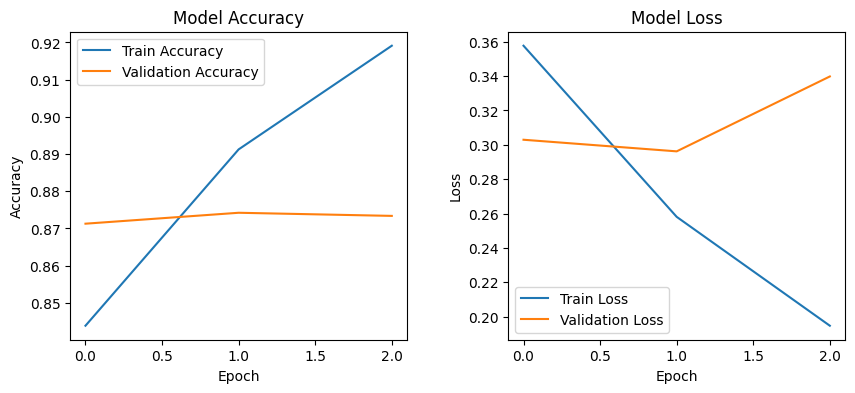

In [53]:
import matplotlib.pyplot as plt

if isinstance(train_accuracies[0], torch.Tensor):
    train_accuracies = [x.cpu().item() for x in train_accuracies]
if isinstance(val_accuracies[0], torch.Tensor):
    val_accuracies = [x.cpu().item() for x in val_accuracies]

if isinstance(train_losses[0], torch.Tensor):
    train_losses = [x.cpu().item() for x in train_losses]
if isinstance(val_losses[0], torch.Tensor):
    val_losses = [x.cpu().item() for x in val_losses]

# Visualization of training results
plt.figure(figsize=(10, 10))

# Plot for Accuracy
plt.subplot(221)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot for Loss
plt.subplot(222)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


### Testing the Trained BERT Model on New Data
This script demonstrates the application of a trained neural network model to new, unseen text data to evaluate its capability in detecting cyberbullying. The text is first preprocessed by tokenizing, removing stopwords, and stemming to format it similarly to the training data. It is then converted into a sequence and padded to match the input shape required by the model. Finally, the model, loaded from saved weights, predicts the category of cyberbullying, illustrating the model's practical use in identifying harmful content in real-world scenarios.

In [55]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Load the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_path = '/content/sample_data/bert_model/'
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the class labels
classes_path = '/content/unique_labels.npy'
classes = np.load(classes_path, allow_pickle=True)

assert model.config.num_labels == len(classes),

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

text = "This guy thinks I am Randi Harper, have we met?"

# Encode and prepare the input
encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=256,
    truncation=True,
    padding='max_length',
    return_tensors='pt',
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

# Make the prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_index = torch.argmax(probs, dim=1).cpu().numpy()[0]

    if predicted_index < len(classes):
        predicted_class = classes[predicted_index]
    else:
        predicted_class = "Unknown class index"

print("Original text:", text)
print("Predicted class:", predicted_class)


Original text: This guy thinks I am Randi Harper, have we met?
Predicted class: other_cyberbullying


In [66]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_path = '/content/sample_data/bert_model/'
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# Load class labels
labels_path = '/content/unique_labels.npy'
labels = np.load(labels_path, allow_pickle=True)

def speech_to_text(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data, language='en-US')
            return text
        except (sr.UnknownValueError, sr.RequestError) as e:
            return f"Speech Recognition Error: {e}"

def analyze_audio(audio_path):
    wav_path = audio_path.replace('.mp3', '.wav')
    convert_mp3_to_wav(audio_path, wav_path)

    # Convert speech to text
    transcribed_text = speech_to_text(wav_path)
    if "Error" in transcribed_text:
        return transcribed_text, 0

    inputs = tokenizer.encode_plus(transcribed_text, add_special_tokens=True, max_length=512,
                                   truncation=True, padding="max_length", return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_index = torch.argmax(probs, axis=1).cpu().numpy()[0]

    # Return class label and confidence
    predicted_label = labels[predicted_index]
    confidence = probs[0, predicted_index].item()

    return predicted_label, confidence

audio_path = '/content/welcome.mp3'
predicted_label, confidence = analyze_audio(audio_path)
print(f"Predicted Label: {predicted_label} with confidence {confidence:.2f}")


Conversion successful.
Predicted Label: other_cyberbullying with confidence 0.69


Kaggle Dataset Link: "https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification"

pretrained word vectors Link "https://www.kaggle.com/datasets/mrugankakarte/glove-6b-200d-pretrained-word-vectors"
